<a href="https://colab.research.google.com/github/CShorten/CORD-19-Mining/blob/main/Tokenization_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2> NLTK Tokenization </h2>

Corresponding article:

In [ ]:
from google.colab import files
files.upload()

In [2]:
!unzip Pdf_Json_1_DataFrame.csv.zip

Archive:  Pdf_Json_1_DataFrame.csv.zip
  inflating: Pdf_Json_1_DataFrame.csv  


In [3]:
import pandas as pd
df = pd.read_csv('Pdf_Json_1_DataFrame.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397541 entries, 0 to 397540
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Sequence  397541 non-null  object
 1   Label     397541 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.1+ MB


In [5]:
import nltk
nltk.download('punkt');

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
from nltk.tokenize import word_tokenize
text = "Exploring the CORD19 Dataset for Evidence Retrieval"
print(word_tokenize(text))

['Exploring', 'the', 'CORD19', 'Dataset', 'for', 'Evidence', 'Retrieval']


In [7]:
%%time
word_tokenize(text);

CPU times: user 239 µs, sys: 0 ns, total: 239 µs
Wall time: 244 µs


['Exploring', 'the', 'CORD19', 'Dataset', 'for', 'Evidence', 'Retrieval']

In [9]:
test = []
for i in range(0, 100):
  test.append("Thanks for checking out this notebook on Tokenization for CORD19")

In [11]:
%%time
for seq in test:
  word_tokenize(seq)

CPU times: user 11.8 ms, sys: 0 ns, total: 11.8 ms
Wall time: 11.7 ms


<h2> Building the Token -> Index Dictionary </h2>

Strategy #1: Top-K most frequent tokens

In [23]:
Index_Token_Dict = {}
# 
new_index_lists = []

Damn this took forever...

In [12]:
%%time
freq_counter = {}
for i in df.Sequence:
  tok_seq = word_tokenize(i)
  for tok in tok_seq:
    if tok in freq_counter.keys():
      freq_counter[tok] += 1
    else:
      freq_counter[tok] = 1

CPU times: user 5min 5s, sys: 770 ms, total: 5min 6s
Wall time: 5min 7s


Sort the Dictionary

In [13]:
import operator
sorted_dict = sorted(freq_counter.items(), key=operator.itemgetter(1))
# credit: https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value

In [14]:
len(sorted_dict)

656159

In [21]:
sorted_dict[-30_000:][:5]

[('scintillation', 41),
 ('inositol', 41),
 ('Proteintech', 41),
 ('stillbirth', 41),
 ('colder', 41)]

In [15]:
sorted_dict[-2:]

[('the', 1567251), (',', 1867586)]

In [ ]:
sorted_dict[-1][0]

','

In [24]:
# use index 30k for UNK token
top_K_list = sorted_dict[-29_999:]

In [26]:
frequency_counters = []
for i in range(len(top_K_list)):
  frequency_counters.append(top_K_list[i][1])

In [27]:
sample = frequency_counters[-50:]

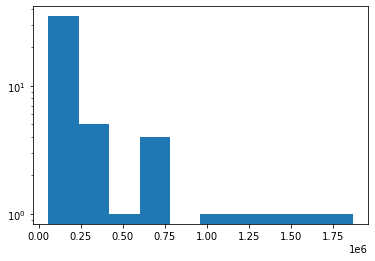

In [28]:
import matplotlib.pyplot as plt 
import seaborn as sns

plt.hist(sample, bins=10);
plt.yscale("log");

In [25]:
top_K_token_index_dict = {}
top_K_index_token_dict = {}
counter = 1

for i in range(len(top_K_list)):
  top_K_token_index_dict[top_K_list[i][0]] = counter
  top_K_index_token_dict[counter] = top_K_list[i][0]
  counter += 1

top_K_index_token_dict[30_000] = "Unknown"

In [44]:
def text_to_index(seq, token_index_dict):
  idx_lst = []
  tok_lst = word_tokenize(seq)
  for tok in tok_lst:
    if tok not in token_index_dict.keys():
      idx_lst.append(30_000)
    else:
      idx_lst.append(token_index_dict[tok])
  return idx_lst

In [45]:
sentence = "hello how are you doing"
text_to_index(sentence, top_K_token_index_dict)

[30000, 29675, 29978, 29143, 25834]

In [ ]:
def index_to_text(idx_list, index_token_dict):
  word = ""
  for idx in idx_list:
    word += index_token_dict[idx]
    word += " "
  return word

In [ ]:
index_to_text([30_000, 29_675, 29_978, 29_143, 25_834], top_K_index_token_dict)

'Unknown how are you doing '

<h2> Save Dictionaries </h2>

In [48]:
import json

token_index_dict_write = json.dumps(top_K_token_index_dict)
f = open("token_index_dict.json","w")
f.write(token_index_dict_write)
f.close()

In [ ]:
index_token_dict_write = json.dumps(top_K_index_token_dict)
f = open("index_token_dict.json", "w")
f.write(index_token_dict_write)
f.close()

<h4> How to load dictionaries </h4>

In [47]:
f = open("token_index_dict.json", "r")
dict_text = f.readlines()[0]

dict_test = json.loads(dict_text)

text_to_index(sentence, dict_test)

[30000, 29675, 29978, 29143, 25834]

In [50]:
# random sample test
freq_counter['how']

11811

<h2> Convert Text to Index Lists and Save in DataFrame </h2>

In [69]:
def build_index_lists(df, text_col_name, text_index_dict):
  index_lists = []
  for seq in df[text_col_name]:
    seq = seq.split(' ')
    new_index_list = []
    for tok in seq:
      if tok in text_index_dict.keys():
        new_index_list.append(str(tok) + " : " + str(text_index_dict[tok]))
      else:
        new_index_list.append(str(tok) + " : " + str(30_000))
    index_lists.append(new_index_list)
  return index_lists

In [70]:
index_lists = build_index_lists(df, "Sequence", top_K_token_index_dict)

<h2> Sanity Check </h2>

In [71]:
df.Sequence[0]

'a1111111111 a1111111111 a1111111111 a1111111111 a1111111111 available data; 78%). In addition, significant increases in the levels of lactate dehydrogenase and α-hydroxybutyrate dehydrogenase were detected in 28 patients (among 34 patients with available data; 82%) and 25 patients (among 34 patients with available data; 74%), respectively. Patchy lesions in lobules were detected by chest computed tomographic scans in 28 patients (82%). Ground-glass opacities, which were a typical feature in adults, were rare in pediatric patients (3%). Rapid radiologic progression and a late-onset pattern of lesions in the lobules were also noticed. Lesions in lobules still existed in 24 (among 32 patients with lesions; 75%) patients that were discharged, although the main symptoms disappeared a few days after treatment. All patients were discharged, and the median duration of hospitalization was 10.00 '

In [72]:
word_tokenize(df.Sequence[0])[:20]

['a1111111111',
 'a1111111111',
 'a1111111111',
 'a1111111111',
 'a1111111111',
 'available',
 'data',
 ';',
 '78',
 '%',
 ')',
 '.',
 'In',
 'addition',
 ',',
 'significant',
 'increases',
 'in',
 'the',
 'levels']

In [73]:
index_lists[0][:20]

['a1111111111 : 21946',
 'a1111111111 : 21946',
 'a1111111111 : 21946',
 'a1111111111 : 21946',
 'a1111111111 : 21946',
 'available : 29854',
 'data; : 30000',
 '78%). : 30000',
 'In : 29963',
 'addition, : 30000',
 'significant : 29846',
 'increases : 29080',
 'in : 29994',
 'the : 29998',
 'levels : 29840',
 'of : 29996',
 'lactate : 25241',
 'dehydrogenase : 24708',
 'and : 29995',
 'α-hydroxybutyrate : 30000']

In [59]:
freq_counter['data']

56381

In [60]:
top_K_token_index_dict['data']

29950

In [61]:
'data' in top_K_token_index_dict.keys()

True

In [ ]:
index_to_text([29990], top_K_index_token_dict)

'a '

<h2> Padding and Truncating to Length 128 </h2>

In [74]:
def pad_to_length_k(org_index_lists, k):
  index_lists = org_index_lists
  for seq_list in index_lists:
    while (len(seq_list) > k):
      seq_list.pop()
    while (len(seq_list) < k):
      seq_list.append(0)
  return index_lists

In [75]:
index_lists = pad_to_length_k(index_lists, 128)

In [76]:
df["Index_Lists"] = index_lists
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397541 entries, 0 to 397540
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Sequence     397541 non-null  object
 1   Label        397541 non-null  int64 
 2   Index_Lists  397541 non-null  object
dtypes: int64(1), object(2)
memory usage: 9.1+ MB


In [77]:
df.to_csv('IdxLists_Pdf_Json_1.csv', index=False)

# Testing the Python File on Github

In [ ]:
# If needed to re-upload code from Github without restarting session
# import shutil
# shutil.rmtree('/path/to/your/dir/')

!git clone https://github.com/CShorten/CORD-19-Mining.git

Cloning into 'CORD-19-Mining'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 81 (delta 40), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (81/81), done.


In [ ]:
import sys, os  
sys.path.append(os.getcwd() + '/CORD-19-Mining/')

from tokenization import text_to_index, index_to_text

In [78]:
text_to_index("hello how are you", top_K_token_index_dict)

[30000, 29675, 29978, 29143]